In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torchinfo import summary

import FrEIA.framework as Ff
import FrEIA.modules as Fm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                        nn.Linear(512,  c_out))
                        
def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

def subnet_conv_1x1(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 1))

In [3]:
def build_model():
    nodes = [Ff.InputNode(3, 32, 32, name='input')]
    ndim_x = 3 * 32 * 32

    # Higher resolution convolutional part
    for k in range(2):
        nodes.append(Ff.Node(nodes[-1],
                            Fm.GLOWCouplingBlock,
                            {'subnet_constructor':subnet_conv, 'clamp':1.2},
                            name=F'conv_high_res_{k}'))
        nodes.append(Ff.Node(nodes[-1],
                            Fm.PermuteRandom,
                            {'seed':k},
                            name=F'permute_high_res_{k}'))

    nodes.append(Ff.Node(nodes[-1], Fm.IRevNetDownsampling, {}))

    # Lower resolution convolutional part
    for k in range(2):
        if k%2 == 0:
            subnet = subnet_conv_1x1
        else:
            subnet = subnet_conv

        nodes.append(Ff.Node(nodes[-1],
                            Fm.GLOWCouplingBlock,
                            {'subnet_constructor':subnet, 'clamp':1.2},
                            name=F'conv_low_res_{k}'))
        nodes.append(Ff.Node(nodes[-1],
                            Fm.PermuteRandom,
                            {'seed':k},
                            name=F'permute_low_res_{k}'))

    # # Make the outputs into a vector, then split off 1/4 of the outputs for the
    # # fully connected part
    # nodes.append(Ff.Node(nodes[-1], Fm.Flatten, {}, name='flatten'))
    # split_node = Ff.Node(nodes[-1],
    #                     Fm.Split,
    #                     {'section_sizes':(ndim_x // 4, 3 * ndim_x // 4), 'dim':0},
    #                     name='split')
    # nodes.append(split_node)

    # # Fully connected part
    # for k in range(2):
    #     nodes.append(Ff.Node(nodes[-1],
    #                          Fm.GLOWCouplingBlock,
    #                          {'subnet_constructor':subnet_fc, 'clamp':2.0},
    #                          name=F'fully_connected_{k}'))
    #     nodes.append(Ff.Node(nodes[-1],
    #                          Fm.PermuteRandom,
    #                          {'seed':k},
    #                          name=F'permute_{k}'))

    # # Concatenate the fully connected part and the skip connection to get a single output
    # nodes.append(Ff.Node([nodes[-1].out0, split_node.out1],
    #                     Fm.Concat1d, {'dim':0}, name='concat'))
    nodes.append(Ff.OutputNode(nodes[-1], name='output'))

    conv_inn = Ff.GraphINN(nodes)

    return conv_inn

conv_inn = build_model()

In [4]:
summary(conv_inn, input_size=(1, 3, 32, 32), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
GraphINN                                 [1, 12, 16, 16]           --
├─ModuleList: 1-1                        --                        --
│    └─0.subnet1.0.weight                                          ├─4,608
│    └─0.subnet1.0.bias                                            ├─256
│    └─0.subnet1.2.weight                                          ├─4,608
│    └─0.subnet1.2.bias                                            ├─2
│    └─0.subnet2.0.weight                                          ├─2,304
│    └─0.subnet2.0.bias                                            ├─256
│    └─0.subnet2.2.weight                                          ├─9,216
│    └─0.subnet2.2.bias                                            ├─4
│    └─1.perm                                                      ├─3
│    └─1.perm_inv                                                  ├─3
│    └─2.subnet1.0.weight                              

Layer (type:depth-idx)                   Output Shape              Param #
GraphINN                                 [1, 12, 16, 16]           --
├─ModuleList: 1-1                        --                        --
│    └─0.subnet1.0.weight                                          ├─4,608
│    └─0.subnet1.0.bias                                            ├─256
│    └─0.subnet1.2.weight                                          ├─4,608
│    └─0.subnet1.2.bias                                            ├─2
│    └─0.subnet2.0.weight                                          ├─2,304
│    └─0.subnet2.0.bias                                            ├─256
│    └─0.subnet2.2.weight                                          ├─9,216
│    └─0.subnet2.2.bias                                            ├─4
│    └─1.perm                                                      ├─3
│    └─1.perm_inv                                                  ├─3
│    └─2.subnet1.0.weight                              

In [5]:
conv_inn = build_model().cuda()
x = torch.randn(1, 3, 32, 32).cuda()
z,jac = conv_inn(x)
z.shape, jac.shape

(torch.Size([1, 12, 16, 16]), torch.Size([1]))

In [6]:
import dnnlib
from torch_utils import misc
from torch.utils.data import Subset

TRAIN_SAMPLES = 2048
BATCH_SIZE = 256

opts = dnnlib.EasyDict(
    data="workdir/datasets/cifar10-32x32.zip",
    xflip=False,
    augment=0.0,
    cond=False,
    cache=True,
    workers=1,
)

# Initialize config dict.
c = dnnlib.EasyDict()
c.dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=opts.data,
    use_labels=opts.cond,
    xflip=opts.xflip,
    cache=opts.cache,
)
c.data_loader_kwargs = dnnlib.EasyDict(
    pin_memory=True, num_workers=opts.workers, prefetch_factor=1,
    batch_size=BATCH_SIZE
)

# Validate dataset options.
dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs)
dataset_name = dataset_obj.name
c.dataset_kwargs.resolution = (
    dataset_obj.resolution
)  # be explicit about dataset resolution
c.dataset_kwargs.max_size = len(dataset_obj)

dataset_obj = dnnlib.util.construct_class_by_name(
    **c.dataset_kwargs
)

# Subset of training dataset
train_ds = Subset(dataset_obj, range(TRAIN_SAMPLES))

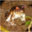

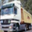

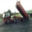

In [7]:
from IPython.display import display
from PIL.Image import fromarray

for i in range(3):
    x = dataset_obj[i][0]
    display(fromarray(x.transpose(1,2,0)))

In [8]:
from flows import train_flow

device = "cuda"

conv_inn = build_model().to(device)
dataset_iterator = torch.utils.data.DataLoader(
        dataset=train_ds, **c.data_loader_kwargs
)

losses = train_flow(conv_inn, dataset_iterator,
                    num_epochs=100, lr=3e-4, device=device)


Loss: 450.3884: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


<AxesSubplot: >

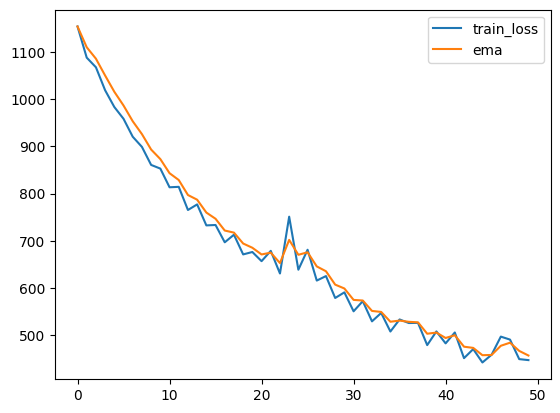

In [9]:
# Plot EMA of losses
df = pd.DataFrame(losses[-50:], columns=['train_loss'])
df['ema'] = df.train_loss.ewm(alpha=0.5).mean()
df.plot()
# plt.yscale('log')

In [10]:
train_ds, dataset_obj

(<torch.utils.data.dataset.Subset at 0x7fc971e69370>,
 <training.dataset.ImageFolderDataset at 0x7fc969b94730>)

In [20]:
from flows import log_density

conv_inn.eval()

# Subset of training dataset
val_ds = Subset(
    dnnlib.util.construct_class_by_name(**c.dataset_kwargs),
    range(TRAIN_SAMPLES, TRAIN_SAMPLES + 256),
)

val_ds_loader = torch.utils.data.DataLoader(dataset=val_ds, **c.data_loader_kwargs)


class OODGenerator:
    def __init__(self, iterator, patch_size=8):
        self.iterator = iterator
        self.psz = patch_size

    def __iter__(self):
        return self

    def __next__(self):
        x, y = next(self.iterator)

        # Modify the element as needed
        x = x.float()
        x[:, :, : self.psz, : self.psz] *= 1 + torch.randn_like(
            x[:, :, : self.psz, : self.psz]
        )

        return x, y


torch.Size([256, 3, 32, 32]) torch.Size([256, 0])


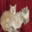

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 3, 32, 32]) torch.Size([256, 0])


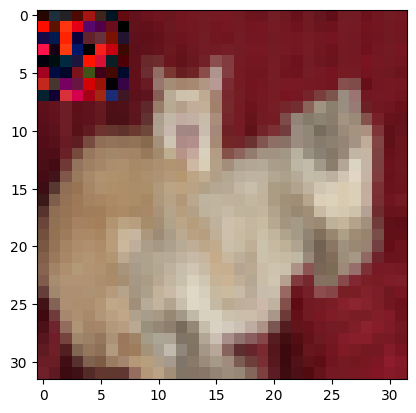

In [21]:
for x,y in val_ds_loader:
    print(x.shape, y.shape)
    x1 = x[0].numpy().transpose(1,2,0)
    display(fromarray(x1))
    x1 = x[0].int().numpy().transpose(1,2,0)
    plt.imshow(x1)

ood_iter = OODGenerator(iter(val_ds_loader))
for x,y in ood_iter:
    print(x.shape, y.shape)
    # x1 = x[0].numpy().transpose(1,2,0)
    # display(fromarray(x1))
    x1 = x[0].numpy().transpose(1,2,0)
    plt.imshow(x1/256)

In [27]:
from flows import log_density

ood_iter = OODGenerator(iter(val_ds_loader))

for x, y in val_ds_loader:
    x = x.float().to(device)
    logpx = log_density(conv_inn, x)

for x, y in ood_iter:
    x = x.float().to(device)
    ood_logpx = log_density(conv_inn, x)


In [30]:
logpx.shape

torch.Size([256, 1, 16, 16])

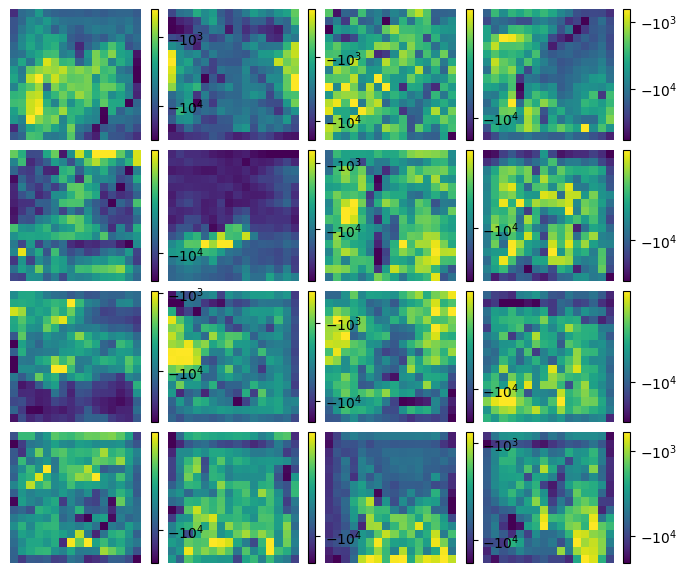

In [28]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colors as colors

# Create a list of images
images = [ximg.float().permute(1,2,0).numpy() for ximg in logpx[:16].cpu()]

# Create a 4x4 grid of images with 0.5 padding
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1, cbar_mode='each')

# Plot each image in a separate grid cell
for ax,cax, im in zip(grid, grid.cbar_axes, images):
    im=ax.imshow(im, norm=colors.SymLogNorm(linthresh=np.abs(np.quantile(im,0.99)),
                                            vmin=np.quantile(im,0.01),
                                            vmax=np.quantile(im,0.99))
)
    cb = cax.colorbar(im)
    ax.axis('off')

In [32]:
val_lls = logpx.mean(dim=(1,2,3)).cpu().numpy()
ood_lls = ood_logpx.mean(dim=(1,2,3)).cpu().numpy()
val_lls.shape, ood_lls.shape

((256,), (256,))

Clipping 95 TPR to: 0.94921875
Clipping 99 TPR to: 0.98046875
Inlier vs Outlier
----------------
ROC-AUC: 95.1538
PR-AUC (In/Out): 96.8422 / 91.4230
FPR (95% TPR): 38.67%
Detection Error: 6.84%
FPR (99% TPR): 81.25%


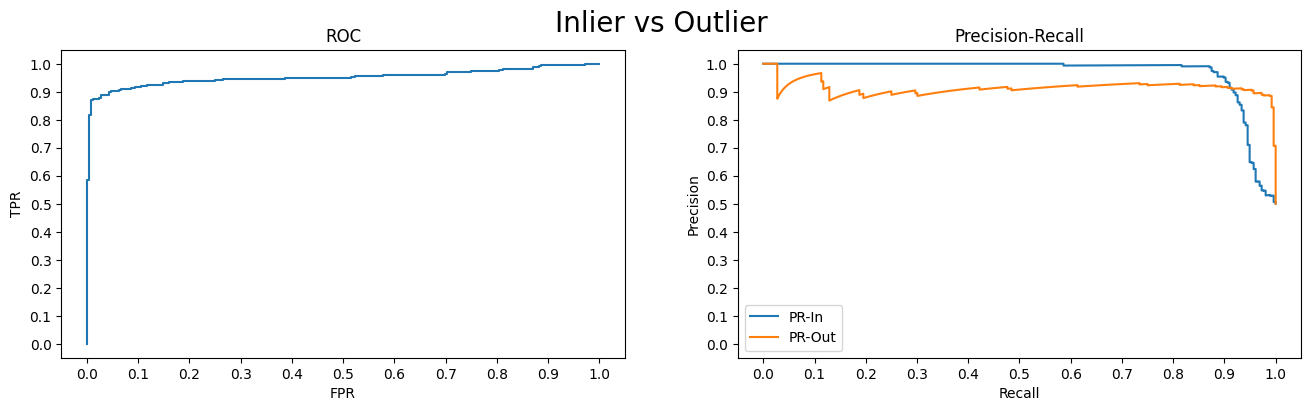

In [37]:
from ood_detection_helper import ood_metrics

ood_metrics(-val_lls, -ood_lls, plot=True, verbose=True);

# TODO: Plot images+heatmaps as overlays

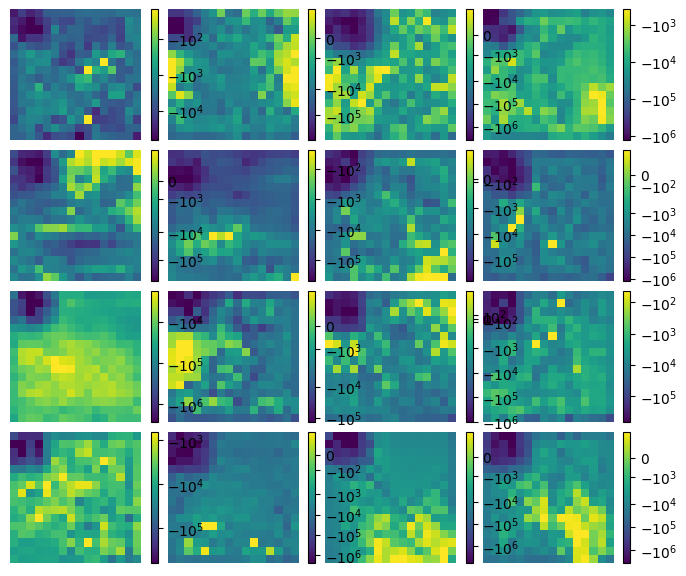

In [ ]:
# Create a list of images
images = [ximg.float().permute(1,2,0).numpy() for ximg in ood_logpx[:16].cpu()]

# Create a 4x4 grid of images with 0.5 padding
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1, cbar_mode='each')

# Plot each image in a separate grid cell
for ax,cax, im in zip(grid, grid.cbar_axes, images):
    im=ax.imshow(im,
                 norm=colors.SymLogNorm(linthresh=np.abs(np.quantile(im,0.99)),
                                        vmin=np.quantile(im,0.01),
                                        vmax=np.quantile(im,0.99)
    ))
    cb = cax.colorbar(im)
    ax.axis('off')

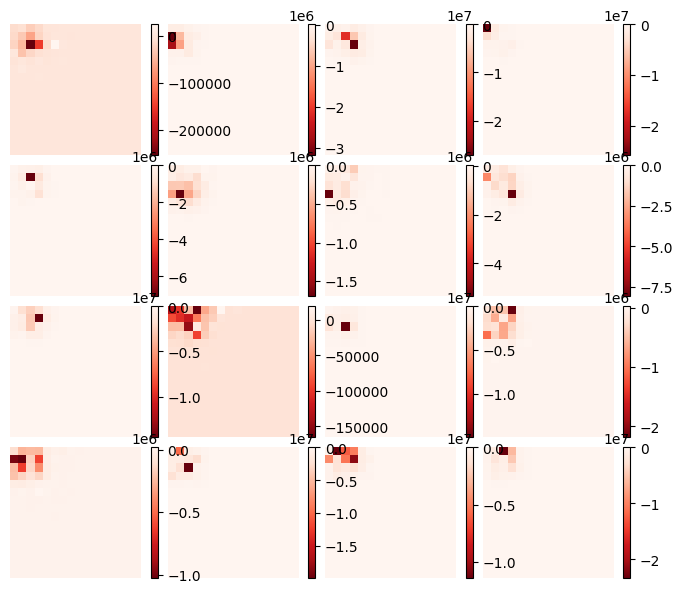

In [ ]:
# Create a list of images
images = [(ood_logpx[i] - logpx[i]).cpu().float().permute(1,2,0).numpy() for i in range(16)]

# Create a 4x4 grid of images with 0.5 padding
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1, cbar_mode='each')

# Plot each image in a separate grid cell
for ax,cax, im in zip(grid, grid.cbar_axes, images):
    im=ax.imshow(im, cmap="Reds_r",)
    cb = cax.colorbar(im)
    ax.axis('off')

Maybe one day you can figure this out..

In [ ]:
# # FLIP TO H,N, W,C
# img = x[:16].cpu().permute(2, 0, 3, 1)
# print(img.shape)
# img = img.reshape(4 * 32, 4 * 32, 3)
# # img = img.permute(1, 2, 0)
# img = img.int().numpy()
# plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


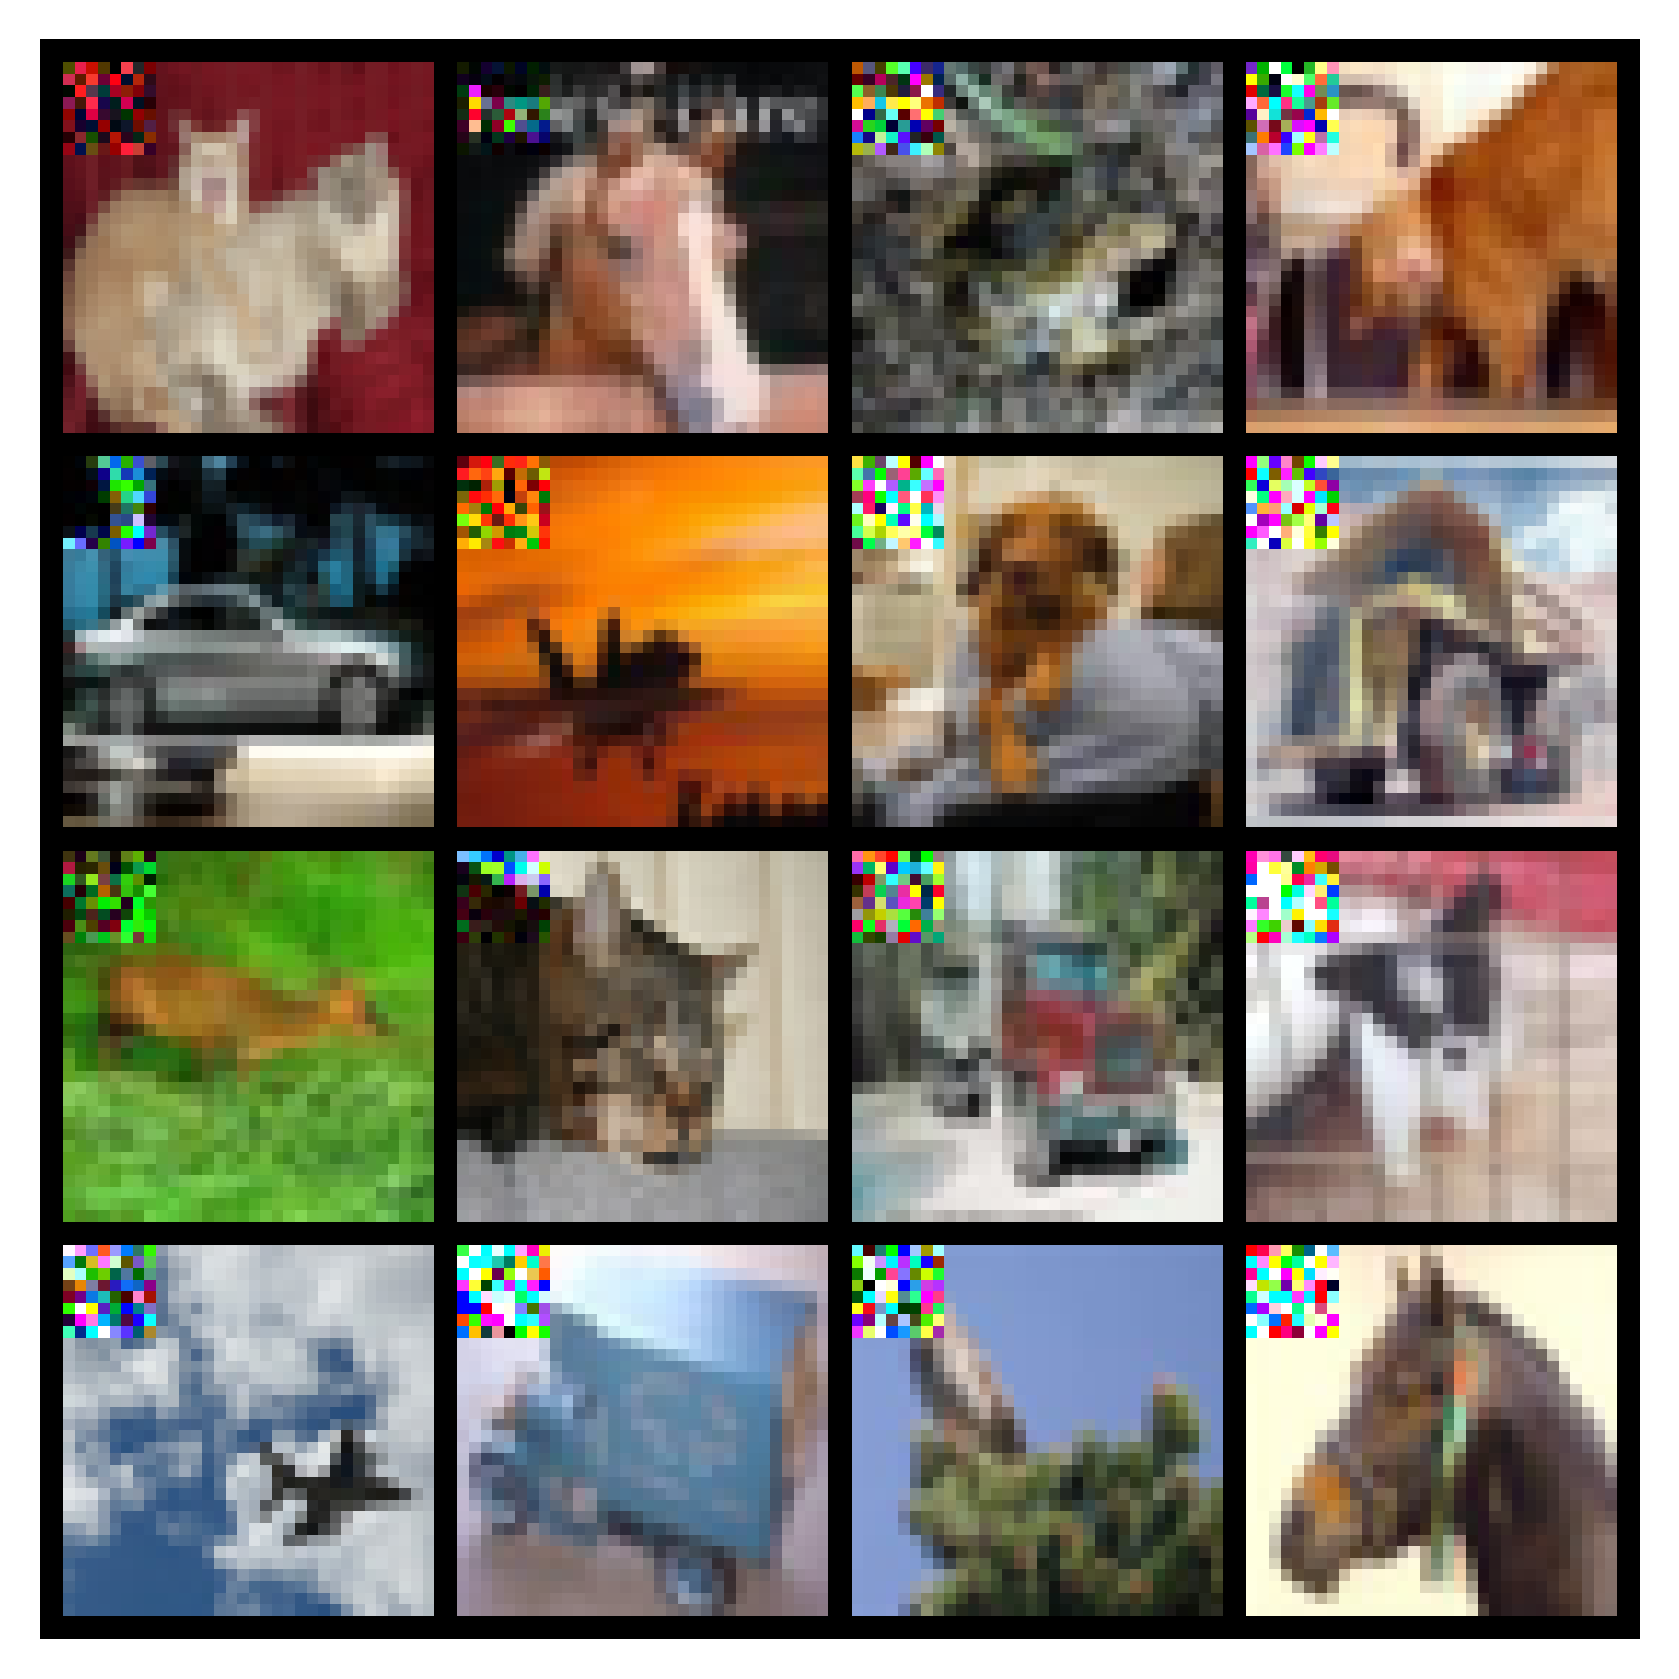

In [ ]:
import torchvision

grid = torchvision.utils.make_grid(x[:16].cpu().int(), nrow=4).permute(1, 2, 0)
fig, axs = plt.subplots(1,1, figsize=(4, 4), dpi=400)
axs.imshow(grid)
plt.axis('off')
plt.tight_layout(pad=0, h_pad=0)

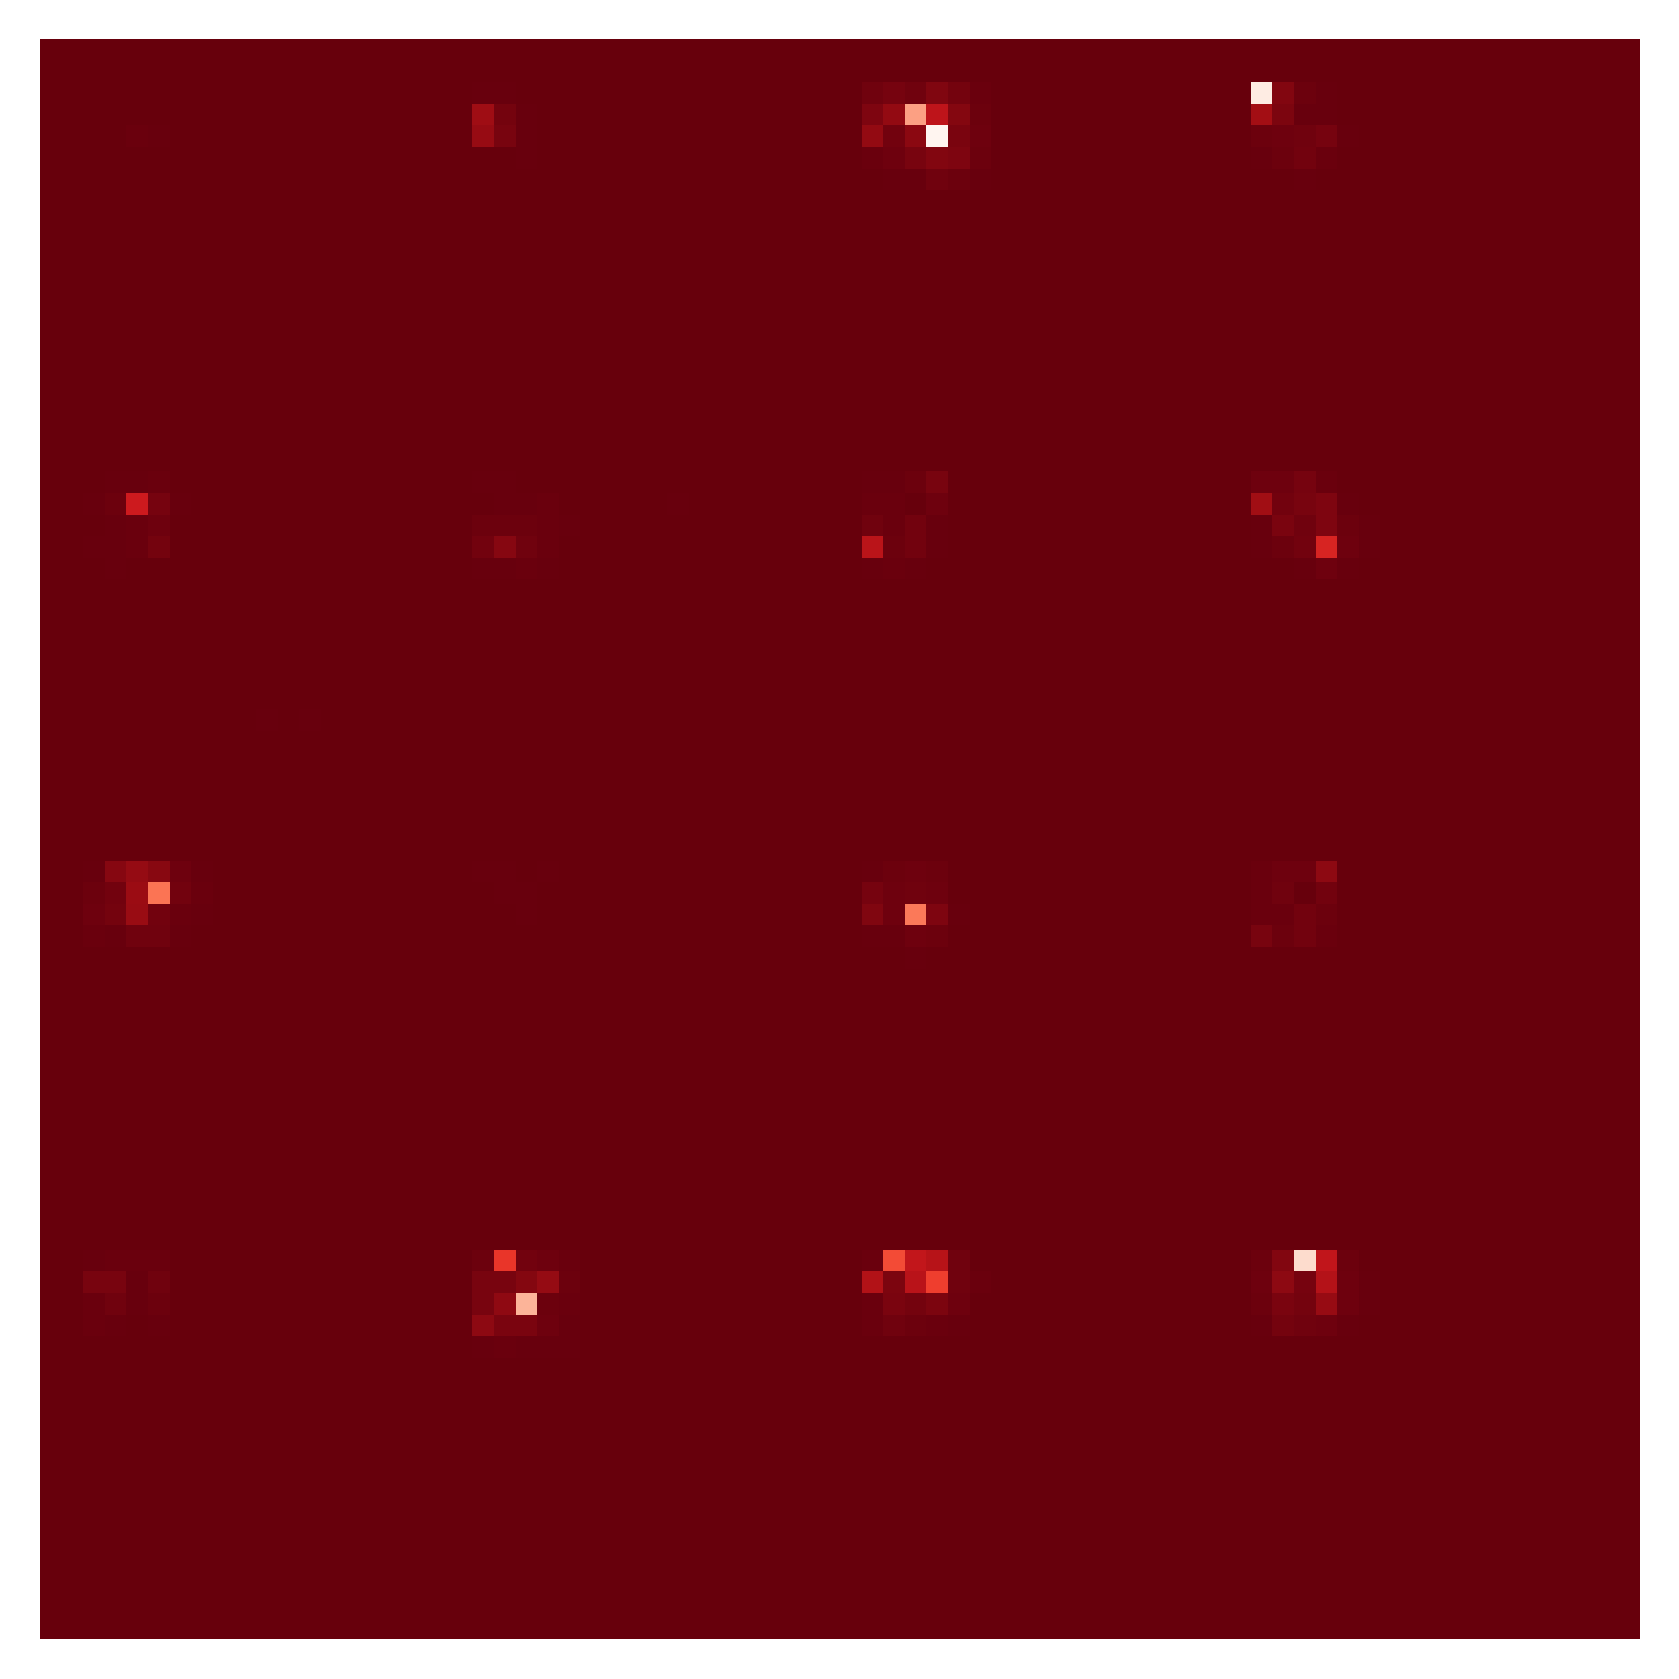

In [ ]:
imglogpx = ood_logpx[:16].cpu()
grid = torchvision.utils.make_grid(imglogpx, nrow=4).permute(1, 2, 0)
fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=400)
axs.imshow(
    grid.mean(axis=2),
    cmap="Reds",
)
plt.axis("off")
plt.tight_layout(pad=0, h_pad=0)
